In [64]:
# import necessary packages
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import imageio
import glob
from IPython import display

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [48]:
# utility function to print images and generate and save images
def show_image(image, num_cols=None):
    num_cols = num_cols or len(image)
    num_rows = (len(image) - 1) // num_cols + 1
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
    plt.figure(figsize=(num_cols, num_rows))
    for x, img in enumerate(image):
        plt.subplot(num_rows, num_cols, 1 + x)
        plt.imshow(img, cmap='binary')
        plt.axis('off')

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))
  for x in range(25):
      plt.subplot(5, 5, 1 + x)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(predictions[x, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [49]:
# load dataset and normalize pixel values from 0-255 using tfutils
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0


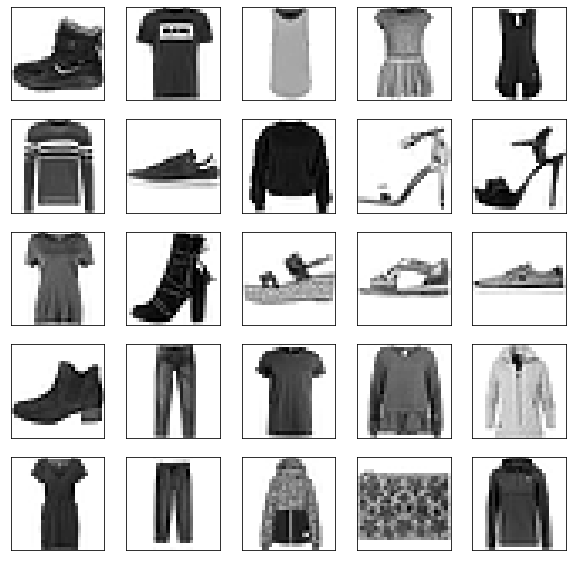

In [50]:
# plotting random examples from dataset
plt.figure(figsize=(10, 10))
for x in range(25):
  plt.subplot(5, 5, 1 + x)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[x], cmap='binary')
plt.show()

In [51]:
# create batches size, buffer size and number of features for training
batch_size = 32
buffer_size = 1000
features_num = 100
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [52]:
# build generator model
generatorModel = Sequential([
    Dense(7 * 7 * 256, input_shape=[features_num]),
    Reshape([7, 7, 256]),
    BatchNormalization(),

    Conv2DTranspose(128, (5, 5), (1, 1), padding='same', activation='selu'),
    BatchNormalization(),

    Conv2DTranspose(64, (5, 5), (2, 2), padding='same', activation='selu'),
    BatchNormalization(),

    Conv2DTranspose(1, (5, 5), (2, 2), padding='same', activation='selu'),
  ])

generatorModel.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 64)      

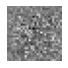

In [53]:
# check for noisy image generated by generator model
noise_image = tf.random.normal(shape=[1, features_num])
generator_image = generatorModel.predict(noise_image)

show_image(generator_image, 1)

In [54]:
# build discriminator model - cnn model to classify images
discriminatorModel = Sequential([
  Conv2D(64, (5, 5), (2, 2), padding='same', input_shape=[28, 28, 1]),
  LeakyReLU(0.2),
  Dropout(0.3),

  Conv2D(128, (5, 5), (2, 2), padding='same'),
  LeakyReLU(0.2),
  Dropout(0.3),

  Conv2D(128, (5, 5), (1, 1), padding='same'),
  LeakyReLU(0.2),
  Dropout(0.3),

  Flatten(),
  Dense(1, activation='sigmoid')
])

# optm = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminatorModel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
discriminatorModel.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)       

In [55]:
# building gan model
baseModel = Sequential([
  generatorModel,
  discriminatorModel
])

discriminatorModel.trainable = False
baseModel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
baseModel.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 28, 28, 1)         2294529   
_________________________________________________________________
sequential_11 (Sequential)   (None, 1)                 622593    
Total params: 2,917,122
Trainable params: 2,293,633
Non-trainable params: 623,489
_________________________________________________________________


In [56]:
# train gan model
seed_image  = tf.random.normal(shape=[batch_size, 100])

def train_dcgan(baseModel, dataset, batch_size, features_num, epochs=5):
    generatorModel, discriminatorModel = baseModel.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for x_batch in dataset:
            noise_image = tf.random.normal(shape=[batch_size, features_num])
            generator_image = generatorModel(noise_image)
            x_fake_and_real_image = tf.concat([generator_image, x_batch], axis=0)
            y_batch = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminatorModel.trainable = True
            discriminatorModel.train_on_batch(x_fake_and_real_image, y_batch)
            noise_image = tf.random.normal(shape=[batch_size, features_num])
            y_batch = tf.constant([[1.]] * batch_size)
            discriminatorModel.trainable = False
            baseModel.train_on_batch(noise_image, y_batch)
        # to generate gif of images produced
        display.clear_output(wait=True)
        generate_and_save_images(generatorModel, epoch + 1, seed_image)
        
    display.clear_output(wait=True)
    generate_and_save_images(generatorModel, epochs, seed_image)


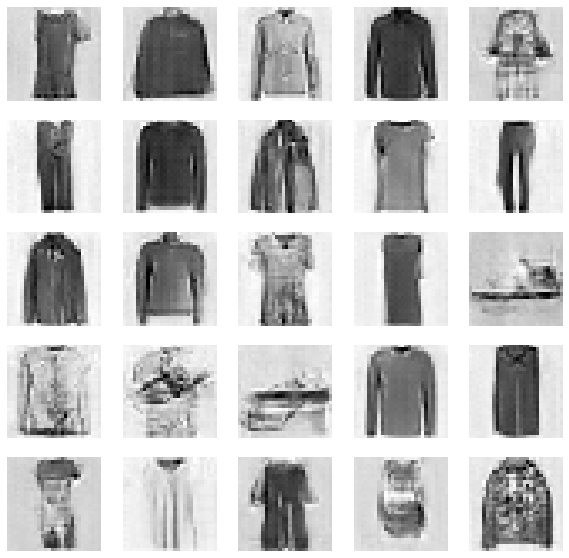

In [57]:
# train gan model
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

train_dcgan(baseModel, dataset, batch_size, features_num, epochs=10)

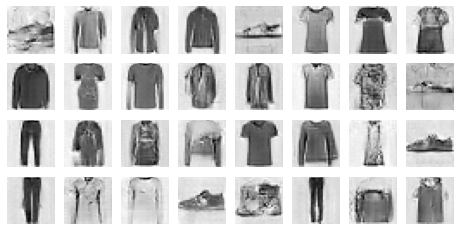

In [58]:
# generate synthetic images
noise_image = tf.random.normal(shape=[batch_size, features_num])
generator_image = generatorModel(noise_image)
show_image(generator_image, 8)

In [65]:
# save animation gif file 
animation_file = 'dcgan.gif'

with imageio.get_writer(animation_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
